In [1]:
!pip install biokit
!pip install dcor
import dcor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn as sk
import os
import math
import time
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
from patsy import dmatrices, dmatrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from biokit.viz import corrplot
import warnings; warnings.simplefilter('ignore')
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler



     |████████████████████████████████| 204kB 2.7MB/s 
     |████████████████████████████████| 61kB 12.7MB/s 
     |████████████████████████████████| 215kB 36.0MB/s 
     |████████████████████████████████| 2.2MB 42.5MB/s 
     |████████████████████████████████| 3.2MB 33.1MB/s 
     |████████████████████████████████| 153kB 33.5MB/s 
  Created wheel for biokit: filename=biokit-0.4.4-cp36-none-any.whl size=212621 sha256=f67ea9069af83d9503fae3ebfdd8e135e2a6f482338f8cd08f0be3e46e6a8781
  Stored in directory: /root/.cache/pip/wheels/48/e4/9e/7eca6f96742d7eee090aa8d5222026413702df9511f7894125
  Created wheel for easydev: filename=easydev-0.9.38-cp36-none-any.whl size=72215 sha256=bfbb36c4a8b9dc3c10b6eda6ad1454a208efdd3a7eaca0785c828bcf008c4d30
  Stored in directory: /root/.cache/pip/wheels/38/93/b7/c4ee5cf6eb4011f7db6467465fe2fb280bbb224a61400bd8a6
  Created wheel for bioservices: filename=bioservices-1.6.0-cp36-none-any.whl size=219217 sha256=604b9400e6830bddd175c15773a228e7a20aa327f3450f762

In [2]:
# Load Dataset from GDrive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# Download a file based on its file ID.
# Master Data
file_id_1 = '1gXsGQZJ71sxHf4SK7TGG2KuAI4miSzGv'
downloaded_1 = drive.CreateFile({'id': file_id_1})
downloaded_1.GetContentFile('Final_Data_v4_for_Modeling_8_24.csv')


     |████████████████████████████████| 993kB 2.6MB/s 


In [3]:
#read the dataset
mstr = pd.read_csv('Final_Data_v4_for_Modeling_8_24.csv')
mstr.head(2)

,year,isAdult,startYear,runtimeMinutes,numVotes,averageRating,Drama,Comedy,Romance,Action,Crime,Thriller,Horror,Adventure,Mystery,Animation,Short,Family,NonFiction,Music,Misc,Fantasy_SciFi,hist_rating,drama_count,comedy_count,romance_count,action_count,crime_count,thriller_count,horror_count,adventure_count,mystery_count,animation_count,short_count,family_count,drama_rating1,comedy_rating1,romance_rating1,action_rating1,crime_rating1,thriller_rating1,horror_rating1,adventure_rating1,mystery_rating1,animation_rating1,short_rating1,family_rating1,movies_seen,user_rating_year,user_rating_month,user_rating_dayofweek,user_rating_weekend_flag,movie_flag,Top100Actor,Target_gt4_rating
0,1989.0,0,1989.0,124.0,41406.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004,9,Monday,0,1,0,1
1,1981.0,0,1981.0,99.0,1034.0,4.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2005,5,Sunday,1,1,0,0


In [4]:
mstr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697143 entries, 0 to 697142
Data columns (total 55 columns):
year                        697143 non-null float64
isAdult                     697143 non-null int64
startYear                   697143 non-null float64
runtimeMinutes              697143 non-null float64
numVotes                    697143 non-null float64
averageRating               697143 non-null float64
Drama                       697143 non-null float64
Comedy                      697143 non-null float64
Romance                     697143 non-null float64
Action                      697143 non-null float64
Crime                       697143 non-null float64
Thriller                    697143 non-null float64
Horror                      697143 non-null float64
Adventure                   697143 non-null float64
Mystery                     697143 non-null float64
Animation                   697143 non-null float64
Short                       697143 non-null float64
Family 

In [5]:
#mstr = pd.concat([
#        mstr.select_dtypes([], ['object']),
#        mstr.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
#        ], axis=1).reindex_axis(mstr.columns, axis=1)

#mstr.info()

#mstr.select_dtypes(['object']).Categorical.from_array.labels
char_cols = mstr.dtypes.pipe(lambda x: x[x == 'object']).index
for c in char_cols:
    mstr.append = mstr[c]
        
mstr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697143 entries, 0 to 697142
Data columns (total 55 columns):
year                        697143 non-null float64
isAdult                     697143 non-null int64
startYear                   697143 non-null float64
runtimeMinutes              697143 non-null float64
numVotes                    697143 non-null float64
averageRating               697143 non-null float64
Drama                       697143 non-null float64
Comedy                      697143 non-null float64
Romance                     697143 non-null float64
Action                      697143 non-null float64
Crime                       697143 non-null float64
Thriller                    697143 non-null float64
Horror                      697143 non-null float64
Adventure                   697143 non-null float64
Mystery                     697143 non-null float64
Animation                   697143 non-null float64
Short                       697143 non-null float64
Family 

In [0]:
corr = mstr[15:].corr(method='spearman')
c = corrplot.Corrplot(corr)
c.plot(method='ellipse', cmap='PRGn_r', shrink=1, rotation=45, upper='text', lower='ellipse')
fig = plt.gcf()
fig.set_size_inches(10, 8);

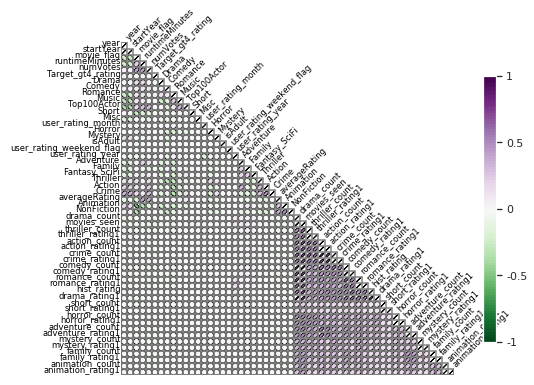

In [8]:
###################################################################
# Corr between column to see if we need PCA                       #
###################################################################

corr = mstr.corr(method='spearman')
c = corrplot.Corrplot(corr)
c.plot(method='ellipse', cmap='PRGn_r', shrink=1, rotation=45,  lower='ellipse')
fig = plt.gcf()
fig.set_size_inches(10, 8);

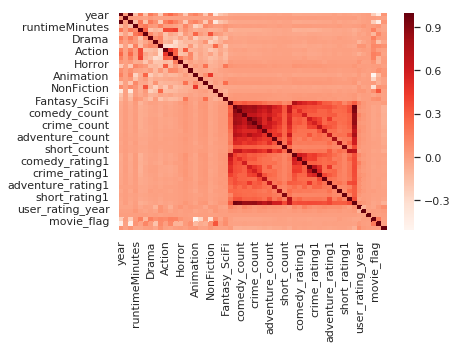

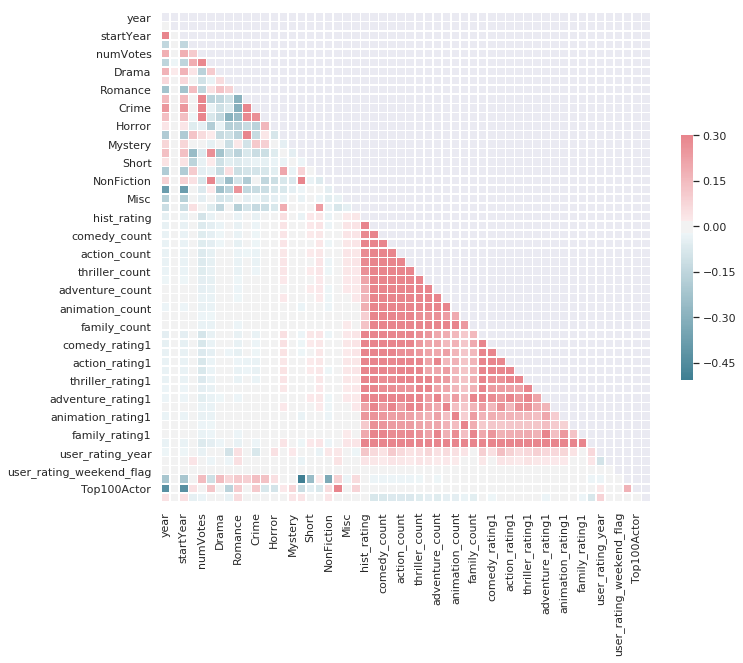

In [9]:
#plt.figure(figsize=(12,10))
cor = mstr.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

# Generate a mask for the upper triangle
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
###################################################################
#                    Distance correlation                         #
###################################################################


def dist_corr(X, Y, pval=True, nruns=2000):
  """ Distance correlation with p-value from bootstrapping
  """
  dc = dcor.distance_correlation(X, Y)
  pv = dcor.independence.distance_covariance_test(X, Y, exponent=1.0, num_resamples=nruns)[0]
  if pval:
    return (dc, pv)
  else:
    return dc

def corrfunc(x, y, **kws):
  d, p = dist_corr(x,y) 
  #print("{:.4f}".format(d), "{:.4f}".format(p))
  if p > 0.1:
    pclr = 'Darkgray'
  else:
    pclr= 'Darkblue'
  ax = plt.gca()
  ax.annotate("DC = {:.2f}".format(d), xy=(.1, 0.99), xycoords=ax.transAxes, color = pclr, fontsize = 14)


g = sns.PairGrid(mstr, diag_sharey=False)
axes = g.axes
g.map_upper(plt.scatter, linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_upper(corrfunc)
g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.fig.set_size_inches(10,10)
plt.show();

In [0]:
#df.corr().unstack().sort_values(ascending = False).drop_duplicates()
cor_target = mstr.corr().unstack().sort_values(ascending = False).drop_duplicates()
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

In [0]:
###################################################################
#                Variance Inflation Factor (VIF)                  #
###################################################################

#gather features
sss='movie_id'
features = "+".join(mstr.columns.difference(["movie_id","year"]))
#features.remove('year')
#print(features)
# get y and X dataframes based on this regression:
y, X = dmatrices('year ~' + features, mstr, return_type='dataframe')

vif = pd.DataFrame()
#print(X.info())
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#print(vif["VIF Factor"])
vif["features"] = X.columns
vif.round(1)
vif.iloc[0,1]="Intercept '"+(sss) +"'"
vif


,VIF Factor,features
0,87.691255,Intercept 'movie_id'
1,1.289232,Top100Actor
2,2.729708,averageRating
3,3.095559,runtimeMinutes
4,1.603376,titleType
5,1.773533,user_rating


In [0]:
###################################################################
#                Variance Inflation Factor (VIF)                  #
###################################################################

def calculate_vif(features, df):

    # get y and X dataframes based on this regression:
    y, X = dmatrices( features, df, return_type='dataframe')

    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    #print(vif)
    vif.round(1)
    return vif

In [0]:
#gather features
variables = [mstr.columns[i] for i in range(mstr.shape[1])]
#features without the response
variables.remove("movie_id")

vif_df = pd.DataFrame([])
#loop do calc vif for all combination features
for c in variables:
  noclubs = [x for x in variables if x != c]
  features = (c+" ~ "+"+".join(noclubs))
  vif = calculate_vif(features,mstr)
  vif.iloc[0,1] = "Intercept '"+(c) +"'"
  vif_df = vif_df.append(vif)
 
vif_df



In [0]:

print(mstr.columns)
print(mstr.head(3))

# Defining the function that you will run later
def calculate_vif_(X, thresh=5.0):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        #print(len(variables))
        #print((variables))
        #print(X.info())
        #print(X[variables].values)

        vif = pd.DataFrame()
        #vif["VIF Factor"]=[variance_inflation_factor(X[variables].values, ix) for ix in range(len(variables))]
        #vif.round(1)
        #print(vif)
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))
        #print(vif)
        #vif=map(round, vif)
        #print(vif)
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return X[[i for i in variables]]

# Select the data without the response
X = mstr

X2 = calculate_vif_(X,5) # Actually running the function


In [0]:
filltered_mstr = mstr[mstr.columns.difference([
    
'year'
,'isAdult'
,'startYear'
,'Drama'
,'Comedy'
,'Romance'
,'Action'
,'Crime'
,'Thriller'
,'Horror'
,'Adventure'
,'Mystery'
,'Animation'
,'Short'
,'Family'
,'NonFiction'
,'Music'
,'Misc'
,'Fantasy_SciFi'
,'Top100Actor'
,'movie_flag'
,'Target_gt4_rating'
,'user_rating_dayofweek' 

])]

In [0]:
filltered_mstr.head(3)

,action_count,action_rating1,adventure_count,adventure_rating1,animation_count,animation_rating1,averageRating,comedy_count,comedy_rating1,crime_count,crime_rating1,drama_count,drama_rating1,family_count,family_rating1,hist_rating,horror_count,horror_rating1,mystery_count,mystery_rating1,numVotes,romance_count,romance_rating1,runtimeMinutes,short_count,short_rating1,thriller_count,thriller_rating1,user_rating_month,user_rating_weekend_flag,user_rating_year
0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41406.0,0.0,0.0,124.0,0.0,0.0,0.0,0.0,9,0,2004
1,0.0,0.0,0.0,0.0,0.0,0.0,4.4,1.0,4.0,0.0,0.0,1.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1034.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,5,1,2005
2,0.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79961.0,0.0,0.0,128.0,0.0,0.0,0.0,0.0,1,0,2005


In [7]:
cat_mstr = mstr[[
'year'
,'isAdult'
,'startYear'
,'Drama'
,'Comedy'
,'Romance'
,'Action'
,'Crime'
,'Thriller'
,'Horror'
,'Adventure'
,'Mystery'
,'Animation'
,'Short'
,'Family'
,'NonFiction'
,'Music'
,'Misc'
,'Fantasy_SciFi'
,'Top100Actor'
,'movie_flag'
,'Target_gt4_rating'
,'user_rating_dayofweek' 

]]
cat_mstr.head(10)

,year,isAdult,startYear,Drama,Comedy,Romance,Action,Crime,Thriller,Horror,Adventure,Mystery,Animation,Short,Family,NonFiction,Music,Misc,Fantasy_SciFi,Top100Actor,movie_flag,Target_gt4_rating,user_rating_dayofweek
0,1989.0,0,1989.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Monday
1,1981.0,0,1981.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Sunday
2,1988.0,0,1988.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,Wednesday
3,1980.0,0,1980.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Wednesday
4,1997.0,0,1997.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Wednesday
5,1994.0,0,1994.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Monday
6,1998.0,0,1998.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Monday
7,1939.0,0,1939.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1,Monday
8,2004.0,0,2004.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Saturday
9,2004.0,0,2004.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Thursday


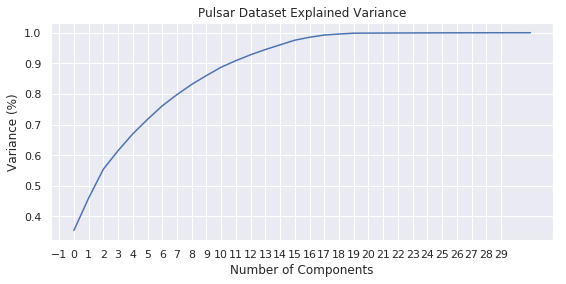

In [8]:

###################################################################
#                Principal component analysis (PCA)                  #
###################################################################

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(filltered_mstr)
#print (data_rescaled)
#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(9, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')

plt.xticks(np.arange(-1, 30, 1))

plt.show()


In [9]:
covar_matrix = PCA(n_components = 18) #we have 20 features

covar_matrix.fit(data_rescaled)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([35.4, 46. , 55.4, 61.5, 67. , 71.7, 76.1, 79.8, 83.1, 86. , 88.7,
       90.8, 92.7, 94.4, 95.9, 97.4, 98.4, 99.1])

In [0]:
pca = PCA(n_components=18)
dataset = pca.fit_transform(data_rescaled)

In [0]:
count = 18
mylist = []

for i in range(count):
   mylist.append('var_' + str(i))

pca_dataset = pd.DataFrame(data = dataset
             , columns = mylist)
pca_dataset.head(10)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17
0,-0.824291,-0.198798,0.091794,0.222698,-0.028597,0.050465,-0.033183,-0.069367,-0.025968,0.002629,0.026779,-0.030081,-0.057624,-0.006156,0.009393,-0.030286,-0.003688,-0.037330
1,0.152734,0.781716,-0.551728,-0.246704,-0.290864,-0.180418,0.511723,0.019827,-0.049677,-0.190016,-0.013291,0.166456,-0.039006,-0.160138,-0.044107,0.288238,-0.005558,0.099589
2,-0.836246,-0.196108,0.084770,-0.491760,0.162592,0.051811,-0.051919,-0.052941,-0.014777,0.012346,0.015784,-0.003134,-0.059278,-0.097437,0.051803,-0.132891,-0.003866,-0.043449
3,0.353969,-0.200982,0.030819,-0.627343,-0.268115,-0.652933,0.106960,0.562030,0.163520,-0.006082,0.382319,-0.304755,0.183259,-0.182920,-0.320441,-0.261488,0.000828,-0.105369
4,1.070404,-0.223710,-0.681977,-0.651350,-0.338937,-0.256021,-0.283921,-0.209313,0.141055,-0.003142,0.137841,-0.263662,0.102806,-0.174937,-0.434693,-0.049242,-0.035722,0.006631
5,1.078344,-0.225145,-0.679876,-0.301352,-0.428059,-0.256151,-0.280696,-0.212516,0.135960,0.001566,0.140199,-0.259269,0.102616,-0.201499,-0.415366,-0.111869,-0.033303,-0.022600
6,1.252331,-0.214281,-0.322210,-0.220760,-0.109094,-0.448716,-0.353252,-0.353310,0.166298,-0.411113,-0.213750,-0.242446,-0.027589,-0.214638,-0.331028,-0.179334,-0.035814,-0.052022
7,1.120659,-0.211945,-0.234210,-0.194635,-0.033173,-0.453942,-0.443859,-0.273623,0.170373,-0.373067,-0.194415,-0.279306,-0.019414,-0.212246,-0.339637,-0.147474,-0.033716,-0.041244
8,-0.822854,0.800997,0.070663,0.513348,-0.121691,0.050021,-0.011216,-0.091040,-0.036282,-0.031692,0.039688,-0.103266,-0.055216,0.274793,-0.052578,0.095522,0.002580,-0.036870
9,0.067919,-0.191772,0.329546,-0.516557,-0.275916,-0.219819,-0.014277,0.384158,-0.068857,0.201783,0.191453,-0.130569,-0.003759,0.110881,0.166497,-0.365352,0.012930,0.444117


In [0]:

dataset_afterPCA = pd.concat([pca_dataset, cat_mstr], axis=1)
dataset_afterPCA.head(10)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,year,isAdult,startYear,Drama,Comedy,Romance,Action,Crime,Thriller,Horror,Adventure,Mystery,Animation,Short,Family,NonFiction,Music,Misc,Fantasy_SciFi,Top100Actor,movie_flag,Target_gt4_rating,user_rating_dayofweek
0,-0.824291,-0.198798,0.091794,0.222698,-0.028597,0.050465,-0.033183,-0.069367,-0.025968,0.002629,0.026779,-0.030081,-0.057624,-0.006156,0.009393,-0.030286,-0.003688,-0.037330,1989.0,0,1989.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Monday
1,0.152734,0.781716,-0.551728,-0.246704,-0.290864,-0.180418,0.511723,0.019827,-0.049677,-0.190016,-0.013291,0.166456,-0.039006,-0.160138,-0.044107,0.288238,-0.005558,0.099589,1981.0,0,1981.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Sunday
2,-0.836246,-0.196108,0.084770,-0.491760,0.162592,0.051811,-0.051919,-0.052941,-0.014777,0.012346,0.015784,-0.003134,-0.059278,-0.097437,0.051803,-0.132891,-0.003866,-0.043449,1988.0,0,1988.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,Wednesday
3,0.353969,-0.200982,0.030819,-0.627343,-0.268115,-0.652933,0.106960,0.562030,0.163520,-0.006082,0.382319,-0.304755,0.183259,-0.182920,-0.320441,-0.261488,0.000828,-0.105369,1980.0,0,1980.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Wednesday
4,1.070404,-0.223710,-0.681977,-0.651350,-0.338937,-0.256021,-0.283921,-0.209313,0.141055,-0.003142,0.137841,-0.263662,0.102806,-0.174937,-0.434693,-0.049242,-0.035722,0.006631,1997.0,0,1997.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Wednesday
5,1.078344,-0.225145,-0.679876,-0.301352,-0.428059,-0.256151,-0.280696,-0.212516,0.135960,0.001566,0.140199,-0.259269,0.102616,-0.201499,-0.415366,-0.111869,-0.033303,-0.022600,1994.0,0,1994.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,Monday
6,1.252331,-0.214281,-0.322210,-0.220760,-0.109094,-0.448716,-0.353252,-0.353310,0.166298,-0.411113,-0.213750,-0.242446,-0.027589,-0.214638,-0.331028,-0.179334,-0.035814,-0.052022,1998.0,0,1998.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Monday
7,1.120659,-0.211945,-0.234210,-0.194635,-0.033173,-0.453942,-0.443859,-0.273623,0.170373,-0.373067,-0.194415,-0.279306,-0.019414,-0.212246,-0.339637,-0.147474,-0.033716,-0.041244,1939.0,0,1939.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1,Monday
8,-0.822854,0.800997,0.070663,0.513348,-0.121691,0.050021,-0.011216,-0.091040,-0.036282,-0.031692,0.039688,-0.103266,-0.055216,0.274793,-0.052578,0.095522,0.002580,-0.036870,2004.0,0,2004.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Saturday
9,0.067919,-0.191772,0.329546,-0.516557,-0.275916,-0.219819,-0.014277,0.384158,-0.068857,0.201783,0.191453,-0.130569,-0.003759,0.110881,0.166497,-0.365352,0.012930,0.444117,2004.0,0,2004.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,Thursday


In [0]:
dataset_afterPCA.to_csv(index=False)

In [0]:
PCA_movies = dataset_afterPCA.to_csv('PCA_moviesV1.csv', index = None, header = True)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import files
files.download('PCA_moviesV1.csv')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 41252, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(filltered_mstr)
#data_rescaled.head(3)


In [0]:
! apt-get install default-jre
!java -version
! pip install h2o
import h2o
import os
# Start up a 1-node H2O cloud on your local machine, and allow it to use all CPU cores and up to 2GB of memory:


h2o.init(max_mem_size = "8G")             #specify max number of bytes. uses all cores by default.
h2o.remove_all()  
frame = h2o.H2OFrame(mstr)
